<a href="https://colab.research.google.com/github/tanvu10/Hidden_Markov_Model/blob/master/HMM_stock_prediction_method_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hmmlearn
from hmmlearn import hmm 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import itertools

In [2]:
stock = pd.read_csv('VNINDEX1.csv')
stock

,Date,Open,High,Low,Close,Volume
0,2000-07-28,100.0000,100.00,100.00,100.00,4200
1,2000-07-31,101.5500,101.55,101.55,101.55,10300
2,2000-08-02,103.3800,103.38,103.38,103.38,300
3,2000-08-04,105.2000,105.20,105.20,105.20,3800
4,2000-08-07,106.9200,106.92,106.92,106.92,13200
...,...,...,...,...,...,...
5137,2021-10-18,1395.5699,1402.63,1390.88,1395.53,740018700
5138,2021-10-19,1395.5300,1399.66,1388.95,1395.33,582318100
5139,2021-10-20,1398.4500,1401.76,1376.15,1393.80,771825800
5140,2021-10-21,1397.5900,1398.45,1384.77,1384.77,659155300


In [3]:
def data_processing(dataframe):        
    # dataframe['Date'] = [i.split(' ')[0][:] for i in dataframe['Date']]
    dataframe['Date'] = dataframe['Date'].apply(pd.Timestamp) #very important: convert string to date
    dataframe = dataframe[dataframe['Date'] >= pd.to_datetime('2015-01-01' , format='%Y-%m-%d')]
    dataframe.set_index(['Date'], inplace = True)
    return dataframe


# def return_cal(dataframe):
#     dataframe['return'] = (dataframe['Close'] - dataframe['Close'].shift(1))/dataframe['Close'].shift(1)
#     dataframe.dropna(inplace  = True)

def features_creating(dataframe):
    new_dataframe = pd.DataFrame()
    new_dataframe['close_return'] = (dataframe['Close'] - dataframe['Close'].shift(1))/dataframe['Close'].shift(1)
    new_dataframe['high_return'] = (dataframe['High'] - dataframe['High'].shift(1))/dataframe['High'].shift(1)
    new_dataframe['low_return'] = (dataframe['Low'] - dataframe['Low'].shift(1))/dataframe['Low'].shift(1)
    # dataframe['vol_change'] = (dataframe['Volume'] - dataframe['Volume'].shift(1))/dataframe['Volume'].shift(1)
    new_dataframe.dropna(inplace  = True)
    return new_dataframe

def all_possible_outcome(num_f1,num_f2,num_f3 ):
    f1 = np.linspace(-0.1, 0.1, num_f1)
    f2 = np.linspace(-0.1, 0.1, num_f2)
    f3 = np.linspace(-0.1, 0.1, num_f3)
    # f4 = np.linspace(-0.1, 0.1, num_f4)
    all_outcome = np.array(list(itertools.product(f1, f2, f3)))
    return all_outcome



In [4]:
stock = data_processing(stock)
train = stock[:'2021-09-01']
test = stock['2021-09-02':]


In [5]:
# stock = stock.iloc[:,5:]
# stock

In [6]:
# train = stock[:'2021-09-01']
# test = stock['2021-09-02':]

In [7]:
def best_state_count(dataframe):
    # aic_vec = []
    bic_vec = []
    M_obs_point = dataframe.shape[1]
    #choose state randomly from 2-6:
    for state in range(2,7):
        param_num = state**2 + state - 1
        #tol: convergence threshold
        #use full cov matrix
        model = hmm.GaussianHMM(n_components=state, covariance_type = 'full', tol = 0.0001, n_iter= 10000)
        model.fit(dataframe.iloc[:, :5])
        
        # aic = -2*model.score(dataframe.iloc[:,:5]) + 2*param_num
        # aic_vec.append(aic)
        bic_vec.append( -2*model.score(dataframe.iloc[:,:5]) + param_num*np.log(M_obs_point) )

    optimal_state = np.argmin(bic_vec)
    return optimal_state

In [8]:
optimal_state = best_state_count(train)
print(optimal_state)

4


In [9]:
def prediction(train, test):
    # train_data = features_creating(train)
    # test_data = features_creating(test)
    test_length = test.shape[0]
    
    # p_prediction = []
    r_prediction = []
    for i in range(test_length+1):
        if i == 0:
            new_train = train
            new_train = features_creating(new_train)
        if i!= 0:
            new_train = pd.concat([train, test.iloc[:i,:]], axis = 0)
            new_train = features_creating(new_train)    

        model = hmm.GaussianHMM(n_components=optimal_state)
        model.fit(new_train)
        a = all_possible_outcome(100,10,10)
        score_init = 0
        for j in range(a.shape[0]):
            new_train = np.array(new_train)
            new_data = np.concatenate((new_train, np.array([a[j,:]])),axis = 0)
            current_score = model.score(new_data)
            if current_score > score_init:
                score_init = current_score
                best_index = j
        
        best_scenario = a[best_index,0]
        r_prediction.append(best_scenario)
    
    return r_prediction



In [10]:
return_vector = prediction(train,test)

In [11]:
new_data = pd.concat([train.iloc[-1:,:], test], axis = 0)
close_data = np.array(new_data['Close']).reshape(-1,1)
return_vector = np.array(return_vector).reshape(-1,1)
# print(close_data[:-1,:])
predicted_price = (close_data*(1+return_vector))
# print(test)
# new_data[:-10]

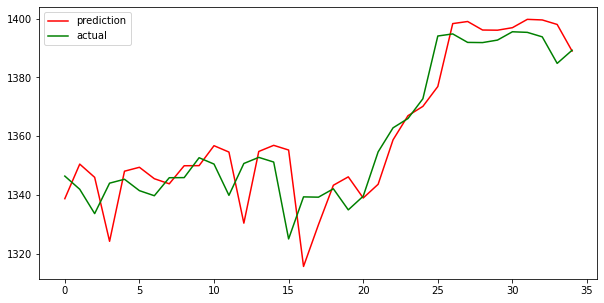

In [12]:
plt.figure(figsize=(10,5))
plt.plot(predicted_price[:-1,:], color  = 'red', label = 'prediction')
plt.plot(np.array(test['Close']), color = 'green', label = 'actual')
plt.legend(loc="upper left")
plt.show()